<IPython.core.display.Javascript object>


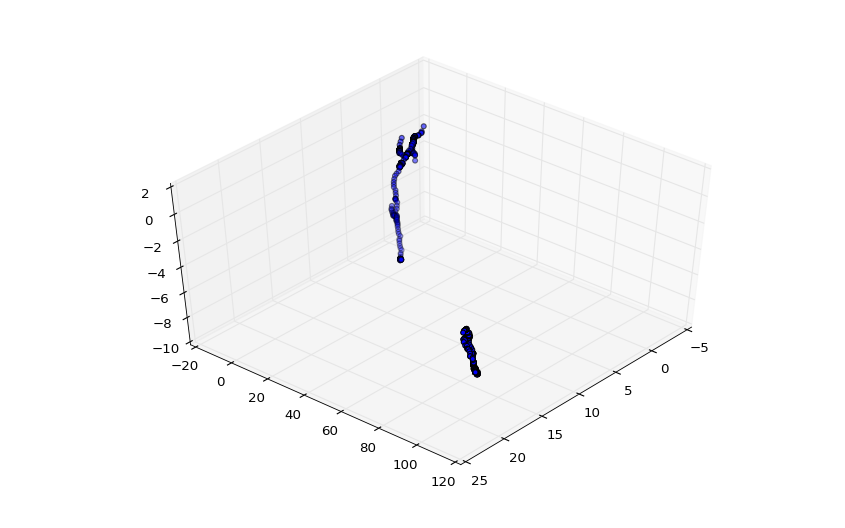

In [1]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import scipy

from parse.event import parse_files, FIELD_KEYS
from coordinates import ecef_to_enu, lla_to_ecef
from glob import iglob
from os import listdir, path

class ENUState:
    
    def __init__(self, max_events):
        self.i = 0
        
        self.xs = np.zeros(max_events)
        self.ys = np.zeros(max_events)
        self.zs = np.zeros(max_events)
        
        self.origin = None
        
    def update(self, filenames):
        # Begin program
        events = [e for e in parse_files(filenames) if "prog_timestamp" in e.fields]
        events.sort(key=lambda e:e.fields['prog_timestamp'])

        if not events:
            return
        
        lats = np.empty(len(events))
        lons = np.empty(len(events))
        alts = np.empty(len(events))
                      
        for i, event in enumerate(events):
            fields = event.fields
            lats[i] = fields['latitude']['value']
            lons[i] = fields['longitude']['value']
            alts[i] = fields['altitude']['value']

        lats = np.radians(lats)
        lons = np.radians(lons)
        
        # Convert to ECEF
        xs_e, ys_e, zs_e = lla_to_ecef(lats, lons, alts)

        # With a default origin of None, we'll take the first point of lat/lon/alt and x/y/z arrays as the origin
        if self.origin is None:
            lat_o = lats[0]
            lon_o = lons[0]
            alt_o = alts[0]

            x_e_o = xs_e[0]
            y_e_o = ys_e[0]
            z_e_o = zs_e[0]
            
            # Pack origin
            self.origin = lat_o, lon_o, x_e_o, y_e_o, z_e_o
            
        # Unpack origin
        lat_o, lon_o, x_e_o, y_e_o, z_e_o = self.origin

        # Convert to ENU
        xs, ys, zs = ecef_to_enu(lat_o, lon_o, x_e_o, y_e_o, z_e_o, xs_e, ys_e, zs_e)

        index = self.i
        N = len(xs)
        new_index = index + N

        self.xs[index:new_index] = xs
        self.ys[index:new_index] = ys
        self.zs[index:new_index] = zs
        
        self.i = new_index
    

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

filenames = set()
state = ENUState(3000)

dir_path = "DroneData/live"

def update_points(ax):    
    curr_filenames = set(listdir(dir_path))
    new_filenames = curr_filenames - filenames
    
    if not new_filenames:
        return
    
    
    __import__("sys").__stdout__.write(str(new_filenames) + "\n")
    try:
        filenames.update(new_filenames)
        new_filenames = [path.join(dir_path, n) for n in new_filenames]    
        state.update(new_filenames)

        ax.clear()
        low = 0# max(state.i-10,0)
        ax.scatter(state.xs[low:state.i], state.ys[low:state.i], state.zs[low:state.i])
        plt.pause(0.0001)
        
        __import__("sys").__stdout__.write(str(state.i) + "\n")
    except Exception as err:
        __import__("sys").__stdout__.write(str(err) + "\n")
        
    

timer = fig.canvas.new_timer(interval=100)
timer.add_callback(update_points, ax)
timer.start()
